# **Amazon Stock Price Forecast: A Time-series Analysis using Rolling OLS Regression**

## **Table of Contents**
- [Introduction](#introduction)
- [Preparation](#preparation)
- [Model Building](#model-building)
- [Model Performance](#model-performance)
- [Conclusion](#conclusion)
- [Appendix](#appendix)

## **Introduction** <a name="introduction"></a>

> #### **Dataset Description**
The New York Stock Exchange Dataset
https://www.kaggle.com/datasets/dgawlik/nyse

##### The dataset consists of daily stock prices from 2010 to 2016 for several hundred stock listings traded on the NYSE. My focus is on the `prices-split-adjusted.csv` file. It is adjusted for splits, which maintains the consistency of the stock prices over time and provides a more accurate reflection of the stock's true value.

##### The key attributes recorded for each trading day include the date, the stock symbol, and the opening, closing, lowest, and highest prices, along with the volume of shares traded. 

> #### **Project Goal**

The primary objective is to develop a predictive model capable of forecasting the closing price of Amazon's stock for a given day, given opening price and the trends in its historical performance data. 

## **Preparation** <a name="preparation"></a>

> #### **Library Packages, Data Imports, and Initialization Settings**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant

from math import sqrt

sns.set_style("darkgrid")
# Adds pandas custom converters for datetime, timestamp, and period
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
# Import the dataset
stockdf = pd.read_csv('prices-split-adjusted.csv')
stockdf['date'] = pd.to_datetime(stockdf['date'])

stockdf.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
# Filter the data to only include prices for Amazon
amazon_stock = stockdf.loc[stockdf.symbol == 'AMZN']

amazon_stock.head()

,date,symbol,open,close,low,high,volume
284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900.0
751,2010-01-05,AMZN,133.429993,134.690002,131.809998,135.479996,8851900.0
1219,2010-01-06,AMZN,134.600006,132.250000,131.649994,134.729996,7178800.0
1687,2010-01-07,AMZN,132.009995,130.000000,128.800003,132.320007,11030200.0
2155,2010-01-08,AMZN,130.559998,133.520004,129.029999,133.679993,9830500.0


> #### **Exploratory Data Analysis**

In [4]:
# Display the default descriptive statistics
amazon_stock.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,337.875664,337.899058,333.969688,341.464438,4.607596e+06
std,189.294231,189.109339,187.654696,190.525796,3.091557e+06
min,105.930000,108.610001,105.800003,111.290001,9.844000e+05
25%,192.962494,193.377506,190.284997,195.532501,2.741550e+06
50%,282.500000,282.915008,279.869995,285.074997,3.890700e+06
75%,398.425003,398.014999,393.799988,402.082496,5.384450e+06
max,845.789978,844.359985,840.599976,847.210022,4.242110e+07


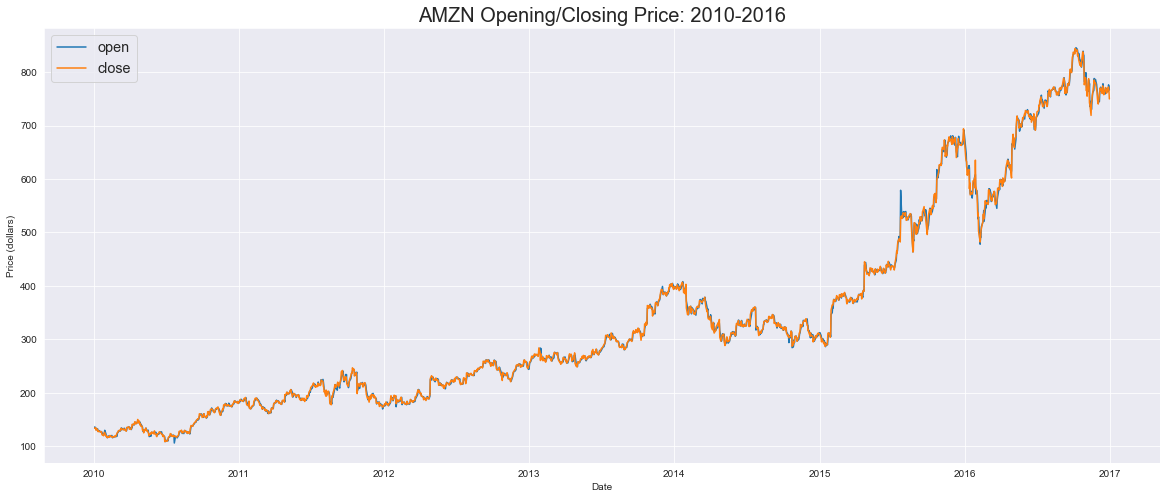

In [5]:
#Opening and closing price line plot for Amazon stock
f, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data = amazon_stock, y = 'open', x = 'date', ax = ax, label = 'open')
sns.lineplot(data = amazon_stock, y = 'close', x = 'date', ax = ax, label = 'close')

ax.set(xlabel='Date',
       ylabel='Price (dollars)')
ax.set_title('AMZN Opening/Closing Price: 2010-2016', fontsize=20)
plt.legend(loc="upper left", fontsize='x-large')

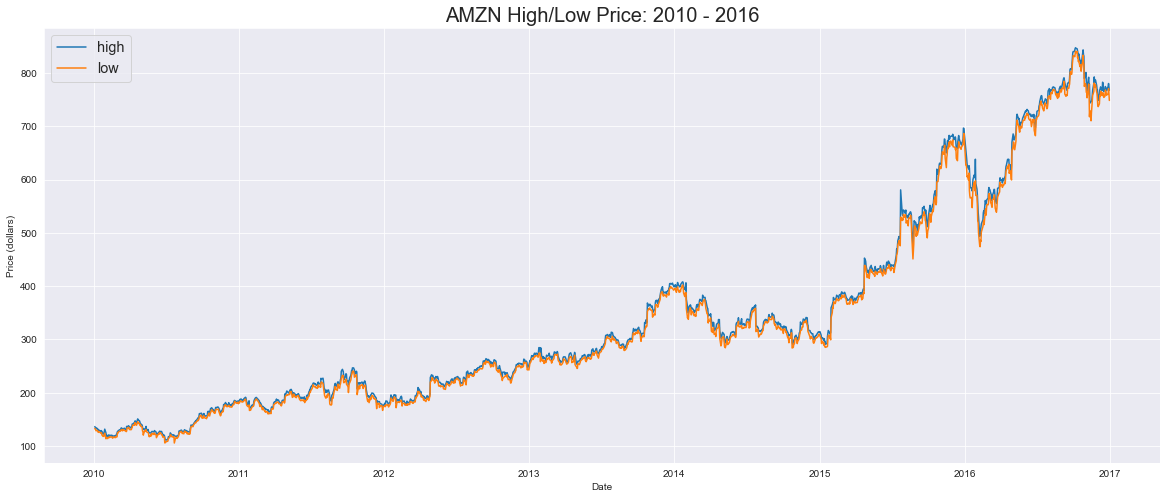

In [6]:
#Daily high and low price line plot for Amazon stock
f, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=amazon_stock, y='high', x='date', label='high')
sns.lineplot(data=amazon_stock, y='low', x='date', label='low')

ax.set(xlabel='Date',
       ylabel='Price (dollars)')
ax.set_title('AMZN High/Low Price: 2010 - 2016', fontsize=20)
plt.legend(loc="upper left", fontsize='x-large')

## **Model Building** <a name="model-building"></a>

> #### **Model Selection**
Rolling OLS Regression: https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html

This model makes predictions time step by time step. After each prediction, the true observation is added to the model for the next prediction. This approach simulates a real-world scenario where new observations for the history are collected and used to update the model over time.

> #### **Time Series Data Labeling**
By setting the date column as the index, time-based operations on the DataFrame can be easily performed

For example, the .loc indexer can be used to select data for a specific date range **(See example 1)**

The .resample() method can resample the data at a different frequency, such as by week or by month **(See example 2)**

In [7]:
# Set the date column as the index
amazon_stock.set_index('date', inplace=True)

In [8]:
# Example 1
amazon_stock.loc['2012-01-01':'2012-12-31']

,symbol,open,close,low,high,volume
date,,,,,,
2012-01-03,AMZN,175.889999,179.029999,175.550003,179.479996,5110800.0
2012-01-04,AMZN,179.210007,177.509995,176.070007,180.500000,4205200.0
2012-01-05,AMZN,175.940002,177.610001,174.050003,178.250000,3809100.0
2012-01-06,AMZN,178.070007,182.610001,177.500000,184.649994,7008400.0
2012-01-09,AMZN,182.759995,178.559998,177.000000,184.369995,5056900.0
...,...,...,...,...,...,...
2012-12-24,AMZN,257.299988,258.619995,256.959991,259.500000,984400.0
2012-12-26,AMZN,257.149994,248.630005,248.039993,257.420013,4152700.0
2012-12-27,AMZN,248.279999,248.309998,242.860001,249.350006,3639300.0


In [9]:
# Example 2
amazon_stock.resample('M').mean()  # resample to monthly frequency

,open,close,low,high,volume
date,,,,,
2010-01-31,128.361578,127.423158,125.657369,129.781053,1.215058e+07
2010-02-28,118.192631,118.021053,116.074737,119.553158,1.106031e+07
2010-03-31,130.296957,130.897391,128.931739,132.098262,6.871417e+06
2010-04-30,140.897143,141.070000,138.889524,143.181904,8.239290e+06
2010-05-31,127.790500,127.606000,124.952000,130.340501,7.045495e+06
...,...,...,...,...,...
2016-08-31,764.291738,764.839127,760.904347,767.613037,2.173930e+06
2016-09-30,786.408096,788.965233,782.495716,793.094761,3.206462e+06
2016-10-31,826.923334,824.439055,819.910473,830.645711,3.669705e+06


> #### **Train/Test set Split**
Model is trained with data from the years 2010-2015, tested on the year 2016 data


In [10]:
# Split the data into training and test sets based on the dates
train = amazon_stock.loc['2010-01-01':'2015-12-31']
test = amazon_stock.loc['2016-01-01':]

> #### **Model Training**

In [11]:
# Add a constant (intercept term) to the predictors
train.loc[:, 'const'] = 1

# Define endog and exog
endog = train['close']
exog = train[['open', 'const']]

# Run the rolling window regression
model = RollingOLS(endog, exog, window=60)
rres = model.fit()

## **Model Performance** <a name="model-performance"></a>

> #### **Predicted Values**
Calculated as the dot product of the parameter values and the predictor values

In [12]:
# Generate predicted values
train['predicted_close'] = np.nan
for i in range(60, len(train)):
    train['predicted_close'].iloc[i] = np.dot(rres.params.iloc[i], train[['open', 'const']].iloc[i])

> #### **Training Set Visualizations**
Visualizing the actual vs predicted values for the training set

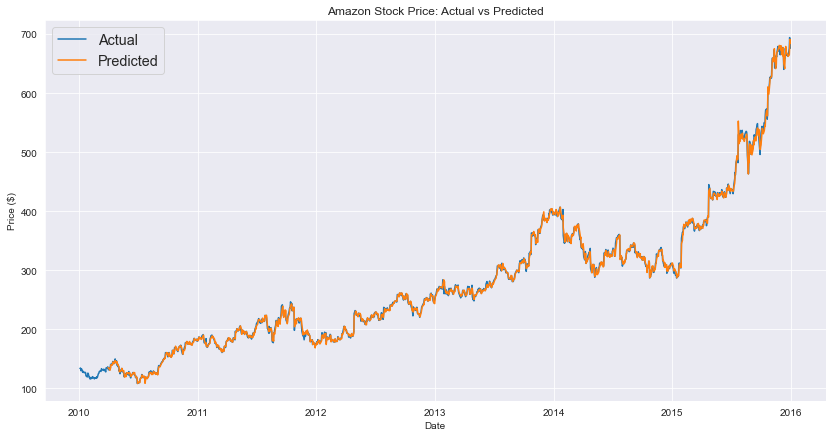

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['close'], label='Actual')
plt.plot(train.index, train['predicted_close'], label='Predicted')

plt.title('Amazon Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc="upper left", fontsize='x-large')

#### The accuracy of the predicted values is hard to tell from the y-scale of the graph, lets zoom in and focus on four specific years.

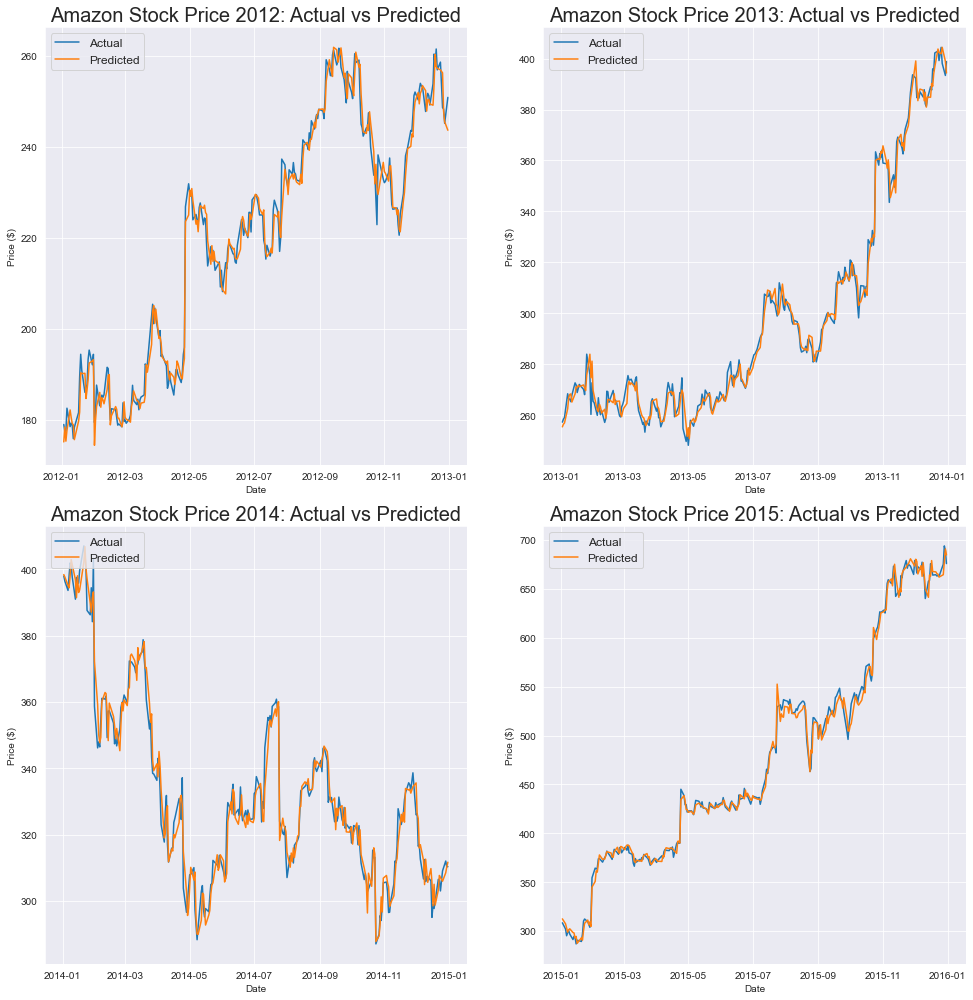

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

years = [2012, 2013, 2014, 2015]

for i, ax in enumerate(axs.flatten()):
    year_data = train[str(years[i])]
    ax.plot(year_data.index, year_data['close'], label='Actual')
    ax.plot(year_data.index, year_data['predicted_close'], label='Predicted')
    ax.set_title(f'Amazon Stock Price {years[i]}: Actual vs Predicted', fontsize=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.legend(loc="upper left", fontsize='large')

plt.tight_layout()

> #### **Root Mean Squared Error (RMSE)**
Measure of overall model prediction error, represent standard deviation of the residuals

In [15]:
#Calculate Root Mean Squared Error for the training set
train_2 = train.dropna()
rmse = np.sqrt(mean_squared_error(train_2['close'], train_2['predicted_close']))
print('Train RMSE:', rmse)

Train RMSE: 4.498317316348356


In this context, an RMSE of approximately `4.50` means that on average, the model's predictions for the closing price of Amazon's stock are about $4.50 away from the actual closing price.

> #### **Test Set  Model**
Generate predicted values for test set

In rolling regression, the parameters of the model are re-estimated at each time step of in the training data. This deals with the concept of out-of-sample forecasting with rolling window models.


The following code uses the most recent model to predict the first point in the test set, then take a time step, re-fit the model and make the next prediction. 

In [16]:
# Define an empty array to store predicted values
predicted_close_test = np.empty(len(test))

# Add a constant (intercept term) to test set
test.loc[:, 'const'] = 1

# For each day in the test set...
for i in range(len(test)):
    # Roll the window one day forward in the combined train and test data
    window = pd.concat([train, test[:i+1]]).iloc[-60:]
    
    # Fit the model to the window and make a prediction for the next day
    endog = window['close']
    exog = window[['open', 'const']]
    model = RollingOLS(endog, exog)
    rres = model.fit()
    predicted_close_test[i] = np.dot(rres.params.iloc[-1], test[['open', 'const']].iloc[i])

# Add the predicted values to the test DataFrame
test['predicted_close'] = predicted_close_test

> #### **Testing Set Visualizations**
Visualizing the actual vs predicted values for the test set

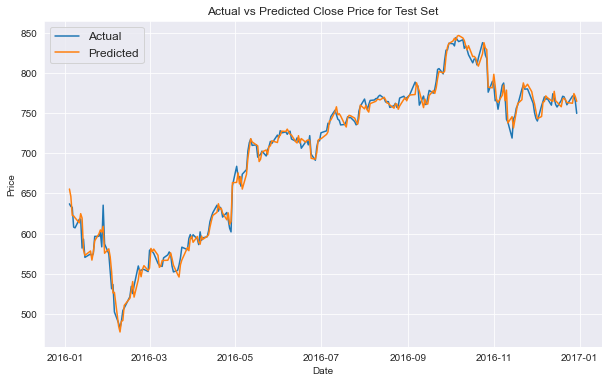

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['close'], label='Actual')
plt.plot(test.index, test['predicted_close'], label='Predicted')
plt.title('Actual vs Predicted Close Price for Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc="upper left", fontsize='large')
plt.show()

> #### **Root Mean Squared Error (RMSE)**
Measure of overall model prediction error, represent standard deviation of the residuals

In [18]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['close'], test['predicted_close']))
print('Test RMSE:', rmse)

Test RMSE: 8.869549414989983


In this context, an RMSE of approximately `8.87` means that on average, the model's predictions for the closing price of Amazon's stock are about $8.87 away from the actual closing price.

## **Conclusion** <a name="conclusion"></a>

In conclusion, the **Rolling Ordinary Least Squares (RollingOLS)** model was effective in capturing the general trend of Amazon's stock prices from 2010 to 2015, indicated by the low RMSE of 4.50 on the training set. 

The model's predictions on the test set data (representing the years 2016) had higher error with an RMSE of 8.87, suggesting a lower level of accuracy when predicting future trends based on historical data.

The visualizations of actual versus predicted closing prices further illustrate this point, showing a closer alignment in the training set compared to the test set. Although the model did managed to capture the overall direction of the stock price movements.

While our model provides a baseline for Amazon's stock price forecasting, it's important to combine such predictions with broader market analysis and other predictive indicators for a more comprehensive investment strategy. Future work could focus on integrating additional variables or using different predictive models to improve the accuracy of stock price predictions.

## **Appendix** <a name="appendix"></a>

> #### **Requirements**

In [19]:
import session_info
session_info.show()